## Data preprocessing

In [1]:
import numpy as np
import pandas as pd

colnames = ["time", "ID", "DLC", "Data1", \
        "Data2", "Data3", "Data4", "Data5", "Data6", "Data7", "Data8", "Attack"]

nRows = 100000 #number of rows that you want
df = pd.read_csv('gear_dataset.csv', nrows = nRows, sep=',', names=colnames)

uniqueIDs = df['ID'].unique() #26 for the entire dataset

#Drop attack packets
attack = df[df['Attack'] == 'T'].copy()
df.drop(attack.index, axis=0, inplace=True)

#Drop DLC = 2 packets
dlc2 = df[df['DLC'] == 2]
df.drop(dlc2.index, axis=0, inplace=True) #drop all dlc2 indexes

#Reset index from 1 to n (not needed actually, so commenting out)
#df.set_index(np.arange(len(df)), inplace=True)

#Pick an ID
#id_data= df[df['ID'] == '0140'].copy()
id_data = df # to use all ids
#Just use data values without time, Attack, ID and DLC right now
dataValues = id_data.drop(["time", "Attack", "ID", "DLC"], axis = 1).copy()
#dataValues.to_csv (r'one_id.csv', index=None)

dataValues = dataValues.to_numpy()


storage = np.zeros((len(dataValues),64), dtype=int)
for currentRow in np.arange(len(storage)):
    
    tempString = "".join(dataValues[currentRow])
    formatted = format(int(tempString, base=16), "064b")
    storage[currentRow,:] = np.array(list(formatted), dtype=int)

In [2]:
print(storage.shape)
n_rows = storage.shape[0]
n_features = storage.shape[1]

(80322, 64)


In [3]:
from matplotlib import pyplot
import keras
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
from numpy import array


In [4]:
#A = array([0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0])
A = array([0,1,1,0,1,0,0,0,0,0,1,1,1,0,0,1,0,0,1,1])
#B = A[::-1] # not sure if this is the way to do it (should it be just each sample that is reversed, or the whole sequence?)

#A = A.reshape((5, 4, 1))
# for x in A:
#     C = A[::-1] 

time_steps = 4
n_features = 1
#n_samples = A.shape[0]
#C = np.flip(A,1)


In [4]:

def overlapping_window (window_size,overlap,seq): # overlap 1 is max. larger number would be less overlap
 
    seq = array([seq[i : i + window_size] for i in range(0, len(seq), overlap)]) 
   
    correct = [len(x)==window_size for x in seq]
    seq = seq[correct]
    seq = np.stack(seq, axis=0 )
    seq = seq.reshape(-1,window_size,1)

    return seq



In [5]:
#time_steps = 40
time_steps = 40
a = np.r_[0:n_rows]
X_train_samples = overlapping_window(time_steps,20,a)
X_train = storage[X_train_samples,:]
X_train = np.squeeze(X_train)
print(X_train.shape)

X_reversed = np.flip(X_train,1)
print(X_reversed[1,0:10,60])
print(X_train[1,30:41,60])

(4015, 40, 64)
[0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0]


In [7]:
# time_steps = 40
# n_features = 64
# 64*40 = 2560 output shape??  
n_samples = X_train.shape[0]
time_steps = X_train.shape[1]
n_features = X_train.shape[2]

lstm_initializer = tf.keras.initializers.RandomUniform(minval=-0.08, maxval=0.08)

AutoEncoder = Sequential()

# Encoder
AutoEncoder.add(Dense(256, activation='tanh', input_shape=(time_steps,n_features)))#,batch_input_shape=(10,time_steps,n_features)))
AutoEncoder.add(Dropout(0.2))

#AutoEncoder.add(LSTM(128, return_sequences=True,stateful = True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer))
AutoEncoder.add(LSTM(128, return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer))
#AutoEncoder.add(LSTM(128, return_sequences=True,stateful = True, kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer))
AutoEncoder.add(LSTM(128, return_sequences=True, kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer))
# Decoder
#AutoEncoder.add(LSTM(128, return_sequences=True,stateful = True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer))
AutoEncoder.add(LSTM(128, return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer))
#AutoEncoder.add(LSTM(128,return_sequences=True,stateful = True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer))
AutoEncoder.add(LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer))
AutoEncoder.add(Dense(256, activation= 'sigmoid'))
AutoEncoder.add(Dense(n_features, activation= 'sigmoid')) # they don't mention this in the article but dimensions are wrong otherwise

AutoEncoder.compile(optimizer='adam', loss='binary_crossentropy')
AutoEncoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40, 256)           16640     
_________________________________________________________________
dropout (Dropout)            (None, 40, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 40, 128)           197120    
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 40, 128)           131584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 40, 128)           131584    
_________________________________________________________________
dense_1 (Dense)              (None, 40, 256)           3

In [6]:
# functional API
# stateful? doesn't really help. initialize cell states in decoder
# parameter search?
n_samples = X_train.shape[0]
time_steps = X_train.shape[1]
n_features = X_train.shape[2]


lstm_initializer = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)

encoderLSTM = LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)
# define Encoder

EncoderInputs = Input(shape=(time_steps,n_features))
#EncoderInputs = Input(batch_shape=(10,time_steps,n_features))
dense1 =Dense(256, activation='tanh')(EncoderInputs)
dropout = Dropout(0.2)(dense1)
#lstm1 = LSTM(128,return_sequences=True)(dropout)
lstm1 = encoderLSTM(dropout)
#lstm2, state_h, state_c = LSTM(128,return_sequences=True,return_state=True)(lstm1)
lstm2, state_h, state_c = LSTM(128,return_sequences=True,return_state=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)(lstm1)
encoder_states = [state_h, state_c]

# define Decoder
  
#lstm3 =  LSTM(128,return_sequences=True)(lstm2,initial_state=encoder_states)
lstm3 =  LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)(lstm2,initial_state=encoder_states)
lstm4 = LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)(lstm3)
#lstm4 = encoderLSTM(lstm3)
dense2 = Dense(256, activation='sigmoid')(lstm4)
#output =  TimeDistributed(Dense(n_features))(dense2)
output = Dense(n_features,activation= 'sigmoid')(dense2)

EncoderDecoder = Model(inputs=EncoderInputs, outputs=output,name="EncoderDecoder")
EncoderDecoder.compile(optimizer='adam', loss='binary_crossentropy')
EncoderDecoder.summary()

#plot_model(EncoderDecoder, to_file='EncoderDecoder.png')

Model: "EncoderDecoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 64)]     0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 40, 256)      16640       input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 40, 256)      0           dense[0][0]                      
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 40, 128)      197120      dropout[0][0]                    
_____________________________________________________________________________________

2810
Epoch 1/300
88/88 - 25s - loss: 0.5291 - val_loss: 0.5167
Epoch 2/300
88/88 - 31s - loss: 0.5016 - val_loss: 0.4793
Epoch 3/300
88/88 - 34s - loss: 0.4203 - val_loss: 0.3691
Epoch 4/300
88/88 - 24s - loss: 0.3234 - val_loss: 0.2780
Epoch 5/300
88/88 - 24s - loss: 0.2353 - val_loss: 0.2117
Epoch 6/300
88/88 - 23s - loss: 0.1851 - val_loss: 0.1806
Epoch 7/300
88/88 - 28s - loss: 0.1596 - val_loss: 0.1626
Epoch 8/300
88/88 - 32s - loss: 0.1443 - val_loss: 0.1513
Epoch 9/300
88/88 - 30s - loss: 0.1342 - val_loss: 0.1434
Epoch 10/300
88/88 - 22s - loss: 0.1267 - val_loss: 0.1373
Epoch 11/300
88/88 - 22s - loss: 0.1209 - val_loss: 0.1323
Epoch 12/300
88/88 - 21s - loss: 0.1161 - val_loss: 0.1278
Epoch 13/300
88/88 - 21s - loss: 0.1118 - val_loss: 0.1240
Epoch 14/300
88/88 - 22s - loss: 0.1078 - val_loss: 0.1203
Epoch 15/300
88/88 - 21s - loss: 0.1043 - val_loss: 0.1169
Epoch 16/300
88/88 - 21s - loss: 0.1010 - val_loss: 0.1138
Epoch 17/300
88/88 - 21s - loss: 0.0978 - val_loss: 0.1109
E

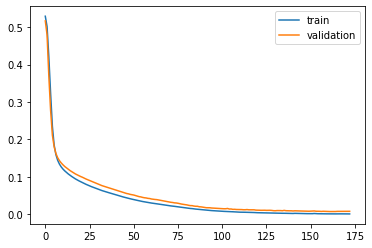

training time = 4293.444295883179 seconds


In [7]:
import time
train_size = int(np.floor(0.7*n_samples))
print(train_size)

model = EncoderDecoder
es= EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

s=time.time()
history = model.fit(X_train[0:train_size,:,:], X_train[0:train_size,:,:], validation_data=(X_train[train_size:,:,:], X_train[train_size:,:,:]), epochs=300, verbose=2, shuffle=False, callbacks = [es])
e=time.time()

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')

pyplot.legend()
pyplot.show()
print(f'training time = {e-s} seconds')

In [8]:
model.save('trained_LSTM_autoencoder_all_ids')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: trained_LSTM_autoencoder_all_ids/assets


In [9]:
reconstructed_model = keras.models.load_model('trained_LSTM_autoencoder_all_ids')


In [57]:
row = 5
#output2 = model.predict(X_train[None,row,:,:])
#real = X_train[row,:,:]
yHat = model.predict(X_train)
real = X_train
errors = real-yHat
print(np.sum(errors))
#print(output2)
print(yHat.shape)
errors = errors.reshape(real.shape[0]*time_steps*n_features)
print(errors.shape)
num_errors = range(len(errors))

pyplot.figure()
pyplot.scatter(num_errors, errors)

pyplot.figure()
pyplot.hist(errors,bins=100, density=True)
pyplot.axis([-0.05, 0.05, 0, 100])

2715.3860488182986
(4015, 40, 64)
(10278400,)


[-0.05, 0.05, 0, 100]

Error in callback <function flush_figures at 0x112832f80> (for post_execute):


KeyboardInterrupt: 

In [11]:
output2[output2<0.5] = 0
output2[output2>0.5] = 1
print(output2)

[[[0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  ...
  [0. 0. 0. ... 1. 1. 0.]
  [0. 0. 0. ... 1. 1. 0.]
  [0. 0. 0. ... 1. 0. 0.]]]


In [12]:
print(X_train[1,:,:])

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 1]]


In [13]:
# ! pip install pydot
n_samples = X_train.shape[0]
time_steps = X_train.shape[1]
n_features = X_train.shape[2]
lstm_initializer = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)

encoderLSTM1 = LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)
encoderLSTM2 =  LSTM(128,return_sequences=True,return_state=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)

decoderLSTM1 = LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)
decoderLSTM2 = LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)

# define Encoder
EncoderInputs = Input(shape=(time_steps,n_features))
dense1 =Dense(256, activation='tanh')(EncoderInputs)
dropout = Dropout(0.2)(dense1)
lstm1 = encoderLSTM1(dropout)
lstm2, state_h, state_c = encoderLSTM2(lstm1)
encoder_states = [state_h, state_c]

# define Decoder
DecoderInputs = Input(shape=())
lstm3 = decoderLSTM1(DecoderInputs,initial_state=encoder_states)
lstm4 = decoderLSTM2(lstm3)
dense2 = Dense(256, activation='sigmoid')(lstm4)
output = Dense(n_features,activation= 'sigmoid')(dense2)

EncoderDecoder = Model(inputs=EncoderInputs, outputs=output,name="EncoderDecoder")
EncoderDecoder.compile(optimizer='adam', loss='binary_crossentropy')
EncoderDecoder.summary()
plot_model(EncoderDecoder, to_file='EncoderDecoder.png')

IndexError: list assignment index out of range

In [ ]:
# look through this and try to decipher what they are doing

from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense

# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(1, n_unique-1) for _ in range(length)]

# prepare data for the LSTM
def get_dataset(n_in, n_out, cardinality, n_samples):
	X1, X2, y = list(), list(), list()
	for _ in range(n_samples):
		# generate source sequence
		source = generate_sequence(n_in, cardinality)
		# define padded target sequence
		target = source[:n_out]
		target.reverse()
		# create padded input target sequence
		target_in = [0] + target[:-1]
		# encode
		src_encoded = to_categorical([source], num_classes=cardinality)
		tar_encoded = to_categorical([target], num_classes=cardinality)
		tar2_encoded = to_categorical([target_in], num_classes=cardinality)
		# store
		X1.append(src_encoded)
		X2.append(tar2_encoded)
		y.append(tar_encoded)
	return array(X1), array(X2), array(y)

# returns train, inference_encoder and inference_decoder models
def define_models(n_input, n_output, n_units):
	# define training encoder
	encoder_inputs = Input(shape=(None, n_input))
	encoder = LSTM(n_units, return_state=True)
	encoder_outputs, state_h, state_c = encoder(encoder_inputs)
	encoder_states = [state_h, state_c]
	# define training decoder
	decoder_inputs = Input(shape=(None, n_output))
	decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
	decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
	decoder_dense = Dense(n_output, activation='softmax')
	decoder_outputs = decoder_dense(decoder_outputs)
	model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
	# define inference encoder
	encoder_model = Model(encoder_inputs, encoder_states)
	# define inference decoder
	decoder_state_input_h = Input(shape=(n_units,))
	decoder_state_input_c = Input(shape=(n_units,))
	decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
	decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
	decoder_states = [state_h, state_c]
	decoder_outputs = decoder_dense(decoder_outputs)
	decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
	# return all models
	return model, encoder_model, decoder_model

# generate target given source sequence
def predict_sequence(infenc, infdec, source, n_steps, cardinality):
	# encode
	state = infenc.predict(source)
	# start of sequence input
	target_seq = array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)
	# collect predictions
	output = list()
	for t in range(n_steps):
		# predict next char
		yhat, h, c = infdec.predict([target_seq] + state)
		# store prediction
		output.append(yhat[0,0,:])
		# update state
		state = [h, c]
		# update target sequence
		target_seq = yhat
	return array(output)




# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# configure problem
n_features = 50 + 1
n_steps_in = 6
n_steps_out = 3
# define model
train, infenc, infdec = define_models(n_features, n_features, 128)
train.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# generate training dataset
X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 100000)
print(X1.shape,X2.shape,y.shape)
# train model
train.fit([X1, X2], y, epochs=1)
# evaluate LSTM
total, correct = 100, 0
for _ in range(total):
	X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 1)
	target = predict_sequence(infenc, infdec, X1, n_steps_out, n_features)
	if array_equal(one_hot_decode(y[0]), one_hot_decode(target)):
		correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))
# spot check some examples
for _ in range(10):
	X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 1)
	target = predict_sequence(infenc, infdec, X1, n_steps_out, n_features)
	print('X=%s y=%s, yhat=%s' % (one_hot_decode(X1[0]), one_hot_decode(y[0]), one_hot_decode(target)))